<div hidden>
    
    $\DeclareMathOperator{\tr}{tr}$
    
</div>    

# Streamed Principal Component Analysis

Análise de Componentes Principais (PCA) é uma das ferramentas básicas em machine learning e estatística não-supervisionada. O objetivo de PCA é reduzir a dimensão dos dados mantendo uma boa parte de sua "informação estatística". Seja $X\in\mathbb{R}^{n\times d}$ a matriz de dados cuja $i$ézima linha $x_i^\top:=X_{i,\bullet}$ é uma amostra $d$-dimensional. Seja $\hat\Sigma := \frac{1}{n}X^\top X$ a matriz de covariância empírica. Por exemplo, a primeira *componente principal* é obtida resolvendo o problema de encontrar o "máximo" auto-vetor da matriz de covariância:

\begin{equation*}
\begin{aligned}
& \underset{w\in\mathbb{R}^{d\times1}}{\text{maximize}}
& & w^\top\hat\Sigma w \\
& \text{sujeito à}
& & w^\top w = 1.
\end{aligned}
\end{equation*}

De fato, podemos resolver um problema parecido para obter as $k$ primeiras componentes principais:

\begin{equation*}
\begin{aligned}
& \underset{W\in\mathbb{R}^{d\times k}}{\text{maximize}}
& & \text{tr}\left(
W^\top\hat\Sigma W 
\right)\\
& \text{sujeito à}
& & W^\top W = I_k.
\end{aligned}
\end{equation*}

O problema àcima é mais precisamente chamado *offline* PCA já que necessita ler toda a matriz de dados $X$ para ser resolvido. Conjunto de dados modernos possuem vetores de dados com dimensão $d$ tão grande que por na memória toda matriz de dados pode ser computacionalmente demandante. Além disso, dados modernos podem ser obtidos via "streaming", de modo que toda a matriz de dados não é observada até o momento.  Uma alternativa é *streaming* ou *online* PCA. Veja [IEEE](https://ieeexplore.ieee.org/document/9638162) para uma aplicação de online PCA para a previsão de voltagem em sistemas de rede elétrica distribuídos. 

O *método de Oja* consiste num método iterativo que tenta resolver PCA lendo apenas um vetor de dados em cada iteração: inicializando-se com uma matriz $W_0$ e escolhendo passos $\eta_t$, iteramos:

1. $Z_{t+1} := (I_{d\times k} + \eta_kx_tx_t^\top)W_t$, onde $x_t$ é o $t$-ézimo vetor de dados.
2. Calcule a decomposição QR de $Z_{t+1}=Q_{t+1}R_{t+1}$.
3. $W_{t+1} := Q_{t+1}$.

Para entender a heurística deste método note que o gradiente da função $f(W)=\text{tr}(W^\top\hat\Sigma W)$ é 

$$
\nabla f(W) = 2\hat\Sigma W = 2\left(\frac{1}{n}\sum_{i=1}^nx_ix_i^\top \right)W.
$$
Portanto, ao implementar o SGD correspondente, $2x_tx_t^\top W$ é uma amostra do gradiente na $t$-ézima iteração (conforme linha 1). As linhas 2-3 correspondem a projetar ortogonalmente $Z_{t+1}$ no conjunto viável $C=\{W\in\mathbb{R}^{d\times k}:W^\top W=I_k\}$. Em conclusão, streaming PCA é o método gradiente (ascendente) estocástico projetado para resolver o problema de PCA populacional.


Começamos carregando alguns módulos necessários:

In [339]:
#Chamando módulos necessários:
import numpy as np
import scipy.linalg as la
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from scipy import sparse as sp
import scipy.sparse.linalg as spla
from time import time

<div hidden> $\DeclareMathOperator{\Diag}{Diag}$ </div>  

# Exercício 1: Dados sintéticos

À seguir, iremos gerar vetores de dados $x_t$ de uma distribuição normal multivariada $N(0,\Sigma)$ cuja matriz de covariância $\Sigma\in\mathbb{R}^{d\times d}$ tem a forma

$$
\Sigma = A_0 Diag(w)^2 A_0^\top + \sigma^2I_d, 
$$

onde $A_0\in\mathbb{R}^{d\times k}$ é uma matriz cujas colunas são vetores ortonormais, $w\in\mathbb{R}^k$ é um vetor com coordenadas $w_k=\frac{u_k}{u_1}$ onde $u_1\ge\cdots\ge u_k$ são gerados independentemente de uma distribuição uniforme $U(0,1)$ e $\sigma>0$. Àcima $Diag(w)$ denota a matriz diagonal cuja diagonal é preenchida com o vetor $w$.

Construa uma função `spiked_covariance(n, d, k, sigma)` com entradas $n$ (o tamanho da amostra), $d$ (dimensão), $k$ e $\sigma$ que retorna $\Sigma$ (`=cov`) da forma àcima, $w$, $A_0$ e matriz de dados $X\in\mathbb{R}^{n\times d}$ cujos vetores linha são gerados de $N(0,\Sigma)$. *Dica*: para gerar uma matriz $n\times k$ com colunas ortonormais você pode aplicar `la.qr()` a uma matriz $n\times k$ cujas entradas são iid $U(0,1)$. Veja as funções `np.random.rand()`, `np.sort()` e `np.random.multivariate_normal()`.

In [340]:
#Escreva código aqui
def spiked_covariance(n, d, k, sigma):
    # Gerando a A0 a partir da decomposição QR de uma matriz uniforme
    Q = la.qr(np.random.uniform(0, 1, (d, k)), mode = "r")[0]
    A0 = Q

    # Gerando w a partir da ordenação de valores uniformes e de sua normalização
    u = np.sort(np.random.uniform(0, 1, k))[::-1]
    w = u/u[0]
    
    # Calculando a matriz de covariâncias
    cov = A0 @ np.diag(w)**2 @ A0.T + sigma**2 * np.eye(d)

    # Gerando a matriz de dados
    X = np.random.multivariate_normal(np.zeros(d), cov, n)

    return cov, w, A0, X

In [341]:
#Exemplo:
n = 500
d = 5
k = 2
sigma = 10*1e-2
cov, w, A0, X = spiked_covariance(n,d,k,sigma)
cov[:6,:6], w[:6], A0[:6,:6], X[:6,:6]

(array([[ 0.93297371, -0.06716089,  0.        ,  0.        ,  0.        ],
        [-0.06716089,  0.06675818,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.01      ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.01      ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.01      ]]),
 array([1.       , 0.3964361]),
 array([[-0.91842446, -0.71109729],
        [ 0.        ,  0.60095375],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]]),
 array([[-0.16326257, -0.10629078, -0.0240166 ,  0.00385665, -0.19594842],
        [ 0.87323696, -0.32883112, -0.18623538,  0.0197544 , -0.02279594],
        [ 0.51801   , -0.52015399,  0.18842584, -0.1006462 ,  0.14646705],
        [ 1.49108144, -0.18949741,  0.08700868, -0.14300528,  0.08921532],
        [-0.72372393, -0.27150804, -0.12270168, -0.12519187, -0.09475661],
        [-0.44196443,  0.17492503,

# Exercício 2: Método de Oja

Construa uma função `Oja(X,cov, k,c,lr_type,random)` que toma como entradas a matriz de dados `X`, a matriz covariância `cov`, o número de componentes principais `k`, número positivo `c`, Boolean `lr_type` onde o passo é $\eta_t=\frac{c}{t}$ se `lr_type=False` e $\eta_t=\frac{c}{\sqrt{t}}$ se `lr_type=True` e Boolean `random` onde o ponto inicial $W_0$ é a origem se `random=False` e randomizado se `random=True`. Tal função deve aplicar o método de Oja e retornar a sequência $\Vert W_t - U_{\bullet,k}\Vert^2_F$ e o último iterado $W_{n}$. Aqui, $U_{\bullet,k}$ é a matriz $d\times k$ cujas colunas são os $k$ primeiros auto-vetores de $\Sigma$.

NOTA: se `random=True`, inicialize o método de Oja tomando $W_0$ como o fator Q da fatorizacão QR de uma matriz $d\times k$ cujas entradas são iid $N(0,1)$. 

In [342]:
#Escreva código aqui
def Oja(X, cov, k, c, lr_type, random):
    d = X.shape[1]
    
    # Inicializando o histórico de erros
    error_history = []

    if random:
        # Inicializa W como a Q a decomposição QR de uma matriz normal padrão
        W = la.qr(np.random.standard_normal((d, k)), mode = "economic")[0]
    else:
        # Inicializa W como uma matriz nula
        W = np.zeros((d, k))

    # Calculando os autovetores de Sigma
    _, eigvectors = la.eigh(cov)
    # Criando a U como os k primeiros autovetores
    U = eigvectors[:, -k:]

    # Calculando o erro e salva na lista
    error = la.norm(W @ W.T - U @ U.T, ord = "fro")**2
    error_history.append(error)

    # Em cada iteração...
    for t in range(X.shape[0]):
        # Calcula o eta
        if lr_type:
            eta = c/np.sqrt(t + 1)
        else:
            eta = c/(t + 1)

        # Pega o t-ésimo dado
        xt = X[t, :].reshape((-1, 1))

        # Atualiza o Z
        Z = W + eta * xt @ (xt.T @ W)
        # Atualiza o W
        W = la.qr(Z, mode = "economic")[0]

        # Calcula o erro e salva na lista
        error = la.norm(W @ W.T - U @ U.T, ord = "fro")**2
        error_history.append(error)

    return error_history, W

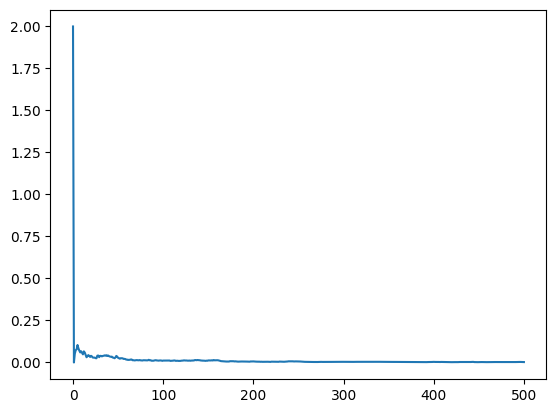

In [343]:
#Exemplo:
# Para F muito grande oscila, para F muito pequeno fica constante e maior do que deveria
F = 10*1e+1
f1 = Oja(X, cov, k, c=F*sigma, lr_type=False, random=False)
 
error_Oja = f1[0]

plt.plot(error_Oja)
plt.show()

# Pergunta:
Tomando:

`n = 500
 d = 5
 k = 2
 sigma = 10*1e-2
 lr_type=False
 random=False
`

plote $\Vert W_t - U_{\bullet,k}\Vert^2_F$ em função do número de iterações $t$ para `F=10*1e-2`,`F=10*1e+1`, `F=10*1e+2`, `F=10*1e+5`. Qual a sua interpretação?

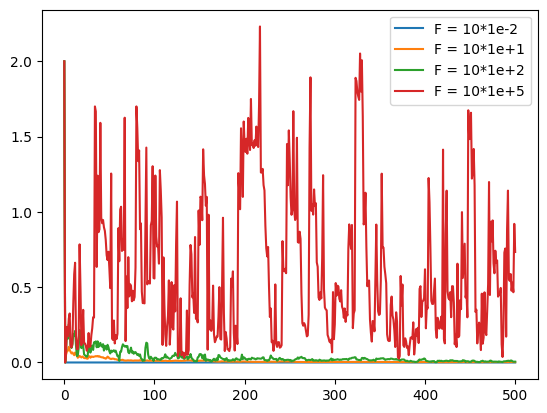

In [344]:
g1 = Oja(X, cov, 2, 10*1e-2 * sigma, lr_type = False, random = False)
g2 = Oja(X, cov, 2, 10*1e+1 * sigma, lr_type = False, random = False)
g3 = Oja(X, cov, 2, 10*1e+2 * sigma, lr_type = False, random = False)
g4 = Oja(X, cov, 2, 10*1e+5 * sigma, lr_type = False, random = False)

plt.plot(g1[0], label = "F = 10*1e-2")
plt.plot(g2[0], label = "F = 10*1e+1")
plt.plot(g3[0], label = "F = 10*1e+2")
plt.plot(g4[0], label = "F = 10*1e+5")

plt.legend()

**Resposta:** Quanto maior o valor de `F`, maior o valor que `c`, que é utilizado no cálculo do tamanho do passo. Assim, com passos maiores, o modelo fica mais instável, justificando a alta oscilação desses casos.

# Exercício 3: AdaOja-Norm

O método de Oja é bastante sensível à calibração do passo $\eta_t$. Iremos implementar uma versão adaptativa do método de Oja baseado no algoritmo Adagrad-Norm. Inicializando-se com uma matriz $W_0$ e escolhendo números positivos $\eta>0$ e $b_0>0$, iteramos:

1. Na $t$-ézima iteração, 
$$
Z_{t+1} := \left(
I_{d\times k} + \frac{\eta}{\sqrt{b_0^2+\sum_{j=1}^{t}\Vert x_jx_j^\top W_j\Vert_F^2}} x_tx_t^\top
\right)W_t,
$$
2. Calcule a decomposição QR de $Z_{t+1}=Q_{t+1}R_{t+1}$.
3. $W_{t+1} := Q_{t+1}$.

Construa uma função `AdaOja(X, cov, k, eta, b0, random)` que toma como entradas a matriz de dados `X`, a matriz covariância `cov`, o número de componentes principais `k`, número positivos `eta` e `b0` e Boolean `random` onde o ponto inicial $W_0$ é a origem se `random=False` e randomizado se `random=True`. Tal função deve aplicar o método  AdaOja-Norm àcima e retornar a sequência $\Vert W_t - U_{\bullet,k}\Vert^2_F$ e o último iterado $W_{n}$. Aqui, $U_{\bullet,k}$ é a matriz $d\times k$ cujas colunas são os $k$ primeiros auto-vetores de $\Sigma$.

NOTA: se `random=True`, inicialize o método  AdaOja tomando $W_0$ como o fator Q da fatorizacão QR de uma matriz $d\times k$ cujas entradas são iid $N(0,1)$.

In [345]:
#Escreva código aqui
def AdaOja(X, cov, k, eta, b0, random):
    d = X.shape[1]
    
    # Inicializando o histórico de erros
    error_history = []

    if random:
        # Inicializa W como a Q a decomposição QR de uma matriz normal padrão
        W = la.qr(np.random.standard_normal((d, k)), mode = "economic")[0]
    else:
        # Inicializa W como uma matriz nula
        W = np.zeros((d, k))

    # Calculando os autovetores de Sigma
    _, eigvectors = la.eigh(cov)
    # Criando a U como os k primeiros autovetores
    U = eigvectors[:, -k:]

    # Calculando o erro e salva na lista
    error = la.norm(W @ W.T - U @ U.T, ord = "fro")**2
    error_history.append(error)

    # Inicializando o somatório
    sumatory = 0

    # Em cada iteração...
    for t in range(X.shape[0]):
        # Pega o t-ésimo dado
        xt = X[t, :].reshape((-1, 1))

        # Incrementa o somatório
        sumatory += la.norm(xt @ xt.T @ W, ord = "fro")**2

        # Atualiza o Z
        Z = W + (eta/(np.sqrt(b0**2 + sumatory))) * xt @ (xt.T @ W)
        # Atualiza o W
        W = la.qr(Z, mode = "economic")[0]

        # Calcula o erro e salva na lista
        error = la.norm(W @ W.T - U @ U.T, ord = "fro")**2
        error_history.append(error)

    return error_history, W

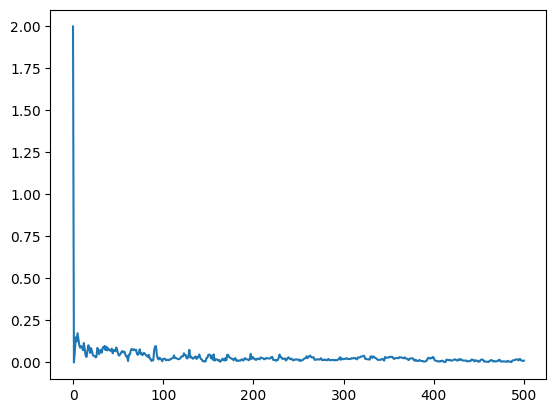

In [346]:
#Exemplo:
F = 10*1e+1
f2 = AdaOja(X, cov, k, eta=F*sigma, b0=1e-5, random=False)
 
error_AdaOja = f2[0]

plt.plot(error_AdaOja)
plt.show()

# Exercício 4: AdaOja-Coordinate

Alternativamente, podemos implementar a versão baseada no Adagrad-Coordinate, a iteração é implementada coordenada a coordenada (semelhante ao método Adam):

1. Na $t$-ézima iteração, 
\begin{align*}
G_t &:= x_tx_t^\top W_t,\\
b_t[j] &:= \sqrt{
b_0^2 + \sum_{j=1}^{t}\Vert G_t[:,j]\Vert_2^2
},\\
Z_{t+1}[:,j] &:= Z_{t}[:,j] + \frac{\eta}{b_t[j]} G_t[:,j].
\end{align*}
2. Calcule a decomposição QR de $Z_{t+1}=Q_{t+1}R_{t+1}$.
3. $W_{t+1} := Q_{t+1}$.

Construa uma função `AdaOja_Coord(X, cov, k, eta, b0, random)` que toma como entradas a matriz de dados `X`, a matriz covariância `cov`, o número de componentes principais `k`, número positivos `eta` e `b0` e Boolean `random` onde o ponto inicial $W_0$ é a origem se `random=False` e randomizado se `random=True`. Tal função deve aplicar o método  AdaOja-Coordindate àcima e retornar a sequência $\Vert W_t - U_{\bullet,k}\Vert^2_F$ e o último iterado $W_{n}$. Aqui, $U_{\bullet,k}$ é a matriz $d\times k$ cujas colunas são os $k$ primeiros auto-vetores de $\Sigma$.

NOTA: se `random=True`, inicialize o método  AdaOja-Coord tomando $W_0$ como o fator Q da fatorizacão QR de uma matriz $d\times k$ cujas entradas são iid $N(0,1)$.

In [347]:
#Escreva código aqui
def AdaOja_Coord(X, cov, k, eta, b0, random):
    d = X.shape[1]
    
    # Inicializando o histórico de erros
    error_history = []
    # Inicializando o Z como uma matriz nula
    Z = np.zeros((d, k))

    if random:
        # Inicializa W como a Q a decomposição QR de uma matriz normal padrão
        W = la.qr(np.random.standard_normal((d, k)), mode = "economic")[0]
    else:
        # Inicializa W como uma matriz nula
        W = np.zeros((d, k))

    # Calculando os autovetores de Sigma
    _, eigvectors = la.eigh(cov)
    # Criando a U como os k primeiros autovetores
    U = eigvectors[:, -k:]

    # Calculando o erro e salva na lista
    error = la.norm(W @ W.T - U @ U.T, ord = "fro")**2
    error_history.append(error)

    # Em cada iteração...
    for t in range(X.shape[0]):
        # Pega o t-ésimo dado
        xt = X[t, :].reshape((-1, 1))

        # Atualiza o G
        G = xt @ (xt.T @ W)

        # Calcula o somatório
        sumatory = la.norm(G[:, :t], ord = "fro")**2

        # Atualiza o b
        b = np.ones(k) * np.sqrt(b0**2 + sumatory)

        # Atualiza o Z
        Z += eta/b * G

        # Atualiza o W
        W = la.qr(Z, mode = "economic")[0]

        # Calcula o erro e salva na lista
        error = la.norm(W @ W.T - U @ U.T, ord = "fro")**2
        error_history.append(error)

    return error_history, W

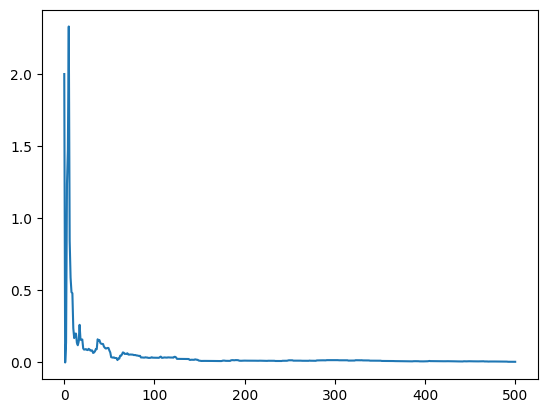

In [348]:
#Exemplo:
F = 10*1e+1
f2 = AdaOja_Coord(X, cov, k, eta=F*sigma, b0=1e-5, random=False)

error_AdaOja_Coord = f2[0]

plt.plot(error_AdaOja_Coord)
plt.show()

# Dados CIFAR-10

Iremos utilizar os dados [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). Ele consiste de 60mil imagens 32x32 com 10 classes. Não usaremos os labels e usaremos apenas os 5 primeiros batches de 50mil imagens com 10mil imagens cada um. Estes correspondem ao dados de treinamento ("training data") com arquivos:

1. data_batch_1
2. data_batch_2
3. data_batch_3
4. data_batch_4
5. data_batch_5

Estes estão na pasta onde este notebook está salvo. Maiores informações sobre como ler os dados CIFAR-10 veja [vídeo](https://www.youtube.com/watch?v=pBOfQTfDMVg) e aplicações de redução de dimensão via PCA no CIFAR-10 em [https://www.kaggle.com/code/adtysregita/pca-application-using-cifar10-dataset](https://www.kaggle.com/code/adtysregita/pca-application-using-cifar10-dataset).


À seguir iremos ler os dados e salvá-los como uma matriz de dados `X`. As imagens estão decodificadas em arquivo texto, portanto temos que ler os dados e transformá-los em imagens. Note que cada linha corresponderá a uma imagem 32x32 *vetorizada*. Mais precisamente, cada linha tem dimensão 3072 correspondente a 3 imagens 32x32, cada uma com os tons de vermelho, azul e verde. Este formato é suficiente para aplicarmos PCA. Ao usarmos todos 5 batches, leva-se um tempo demorado para o método de Oja processar todas as 50000 iterações. Portanto, iremos dar a opção de escolher os `m` primeiros batches para colocar da matriz de dados `X`.

In [349]:
# Criando uma função para ler os dados e transformá-los em imagens, salvas em um dicionário python:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [350]:
#Exemplo:
unpickle('data_batch_2')[b'data'].shape, unpickle('data_batch_2')[b'data']

((10000, 3072),
 array([[ 35,  27,  25, ..., 169, 168, 168],
        [ 20,  20,  18, ..., 111,  97,  51],
        [116, 115, 155, ...,  18,  84, 124],
        ...,
        [127, 139, 155, ..., 197, 192, 191],
        [190, 200, 208, ..., 163, 182, 192],
        [177, 174, 182, ..., 119, 127, 136]], dtype=uint8))

In [351]:
# Colocando m batches em uma única matriz de dados X e escolhendo k:
db = []
m = 1
k = 1

for i in range(1, m+1):
    db.append(unpickle('data_batch_' + str(i))[b'data'])
CIFAR = np.vstack(db)

# Centralizando os dados:
X = CIFAR - CIFAR.mean(axis=0)

# Exercício 6: Método de Oja em CIFAR-10

Construa uma função `Oja_real(X,k,c,lr_type,random)` que toma como entradas a matriz de dados `X`, o número de componentes principais `k`, número positivo `c`, Boolean `lr_type` onde o passo é $\eta_t=\frac{c}{t}$ se `lr_type=False` e $\eta_t=\frac{c}{\sqrt{t}}$ se `lr_type=True` e Boolean `random` onde o ponto inicial $W_0$ é a origem se `random=False` e randomizado se `random=True`. Tal função deve aplicar o método de Oja e retornar a sequência $\Vert W_t \Vert^2_F$ e o último iterado $W_{n}$.

NOTA: se `random=True`, inicialize o método de Oja tomando $W_0$ como o fator Q da fatorizacão QR de uma matriz $d\times k$ cujas entradas são iid $N(0,1)$. 

In [352]:
#Escreva código aqui
def Oja_real(X, k, c, lr_type, random):
    d = X.shape[1]
    
    # Inicializando o histórico de erros
    error_history = []

    if random:
        # Inicializa W como a Q a decomposição QR de uma matriz normal padrão
        W = la.qr(np.random.standard_normal((d, k)), mode = "economic")[0]
    else:
        # Inicializa W como uma matriz nula
        W = np.ones((d, k))

    # Calculando o erro e salva na lista
    error = la.norm(W, ord = "fro")**2
    error_history.append(error)

    # Em cada iteração...
    for t in range(X.shape[0]):
        # Calcula o eta
        if lr_type:
            eta = c/np.sqrt(t + 1)
        else:
            eta = c/(t + 1)

        # Pega o t-ésimo dado
        xt = X[t, :].reshape((-1, 1))

        # Atualiza o Z
        Z = W + eta * xt @ (xt.T @ W)
        # Atualiza o W
        W = la.qr(Z, mode = "economic")[0]

        # Calcula o erro e salva na lista
        error = la.norm(W, ord = "fro")**2
        error_history.append(error)

    return error_history, W

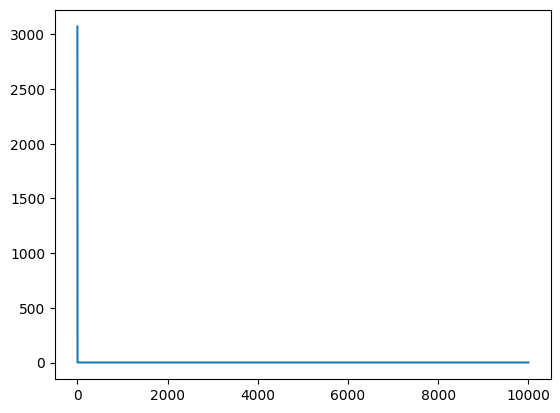

In [353]:
#Exemplo:
ans1 = Oja_real(X, k, c=10*1e-1, lr_type=False, random=False)
error_Oja_real = ans1[0]

plt.plot(error_Oja_real)
plt.show()

# Exercício 7: AdaOja-Norm em CIFAR-10

Construa uma função `AdaOja_real(X, k, eta, b0, random)` que toma como entradas a matriz de dados `X`, o número de componentes principais `k`, número positivos `eta` e `b0` e Boolean `random` onde o ponto inicial $W_0$ é a origem se `random=False` e randomizado se `random=True`. Tal função deve aplicar o método  AdaOja-Norm àcima e retornar a sequência $\Vert W_t\Vert^2_F$ e o último iterado $W_{n}$.

NOTA: se `random=True`, inicialize o método  AdaOja tomando $W_0$ como o fator Q da fatorizacão QR de uma matriz $d\times k$ cujas entradas são iid $N(0,1)$.

In [354]:
#Escreva código aqui
def AdaOja_real(X, k, eta, b0, random):
    d = X.shape[1]
    
    # Inicializando o histórico de erros
    error_history = []

    if random:
        # Inicializa W como a Q a decomposição QR de uma matriz normal padrão
        W = la.qr(np.random.standard_normal((d, k)), mode = "economic")[0]
    else:
        # Inicializa W como uma matriz nula
        W = np.ones((d, k))

    # Calculando o erro e salva na lista
    error = la.norm(W, ord = "fro")**2
    error_history.append(error)

    # Inicializando o somatório
    sumatory = 0

    # Em cada iteração...
    for t in range(X.shape[0]):
        # Pega o t-ésimo dado
        xt = X[t, :].reshape((-1, 1))

        # Incrementa o somatório
        sumatory += la.norm(xt @ (xt.T @ W), ord = "fro")**2

        # Atualiza o Z
        Z = W + (eta/(np.sqrt(b0**2 + sumatory))) * xt @ (xt.T @ W)
        # Atualiza o W
        W = la.qr(Z, mode = "economic")[0]

        # Calcula o erro e salva na lista
        error = la.norm(W, ord = "fro")**2
        error_history.append(error)

    return error_history, W

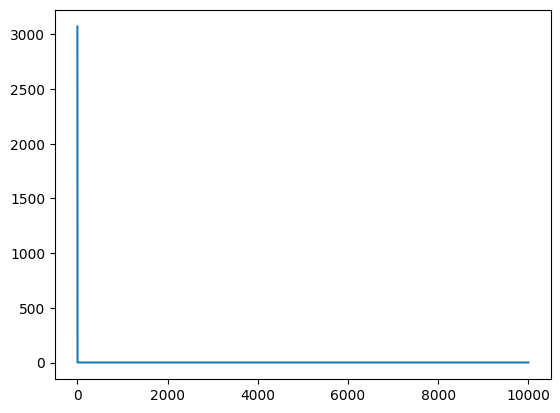

In [355]:
#Exemplo:
ans2 = AdaOja_real(X, k, eta=10*1e-1, b0=1e-5, random=False)
 
error_AdaOja_real = ans2[0]

plt.plot(error_AdaOja_real)
plt.show()

# Exercício 8: AdaOja-Coord em CIFAR-10

Construa uma função `AdaOja_Coord_real(X, k, eta, b0, random)` que toma como entradas a matriz de dados `X`, o número de componentes principais `k`, número positivos `eta` e `b0` e Boolean `random` onde o ponto inicial $W_0$ é a origem se `random=False` e randomizado se `random=True`. Tal função deve aplicar o método  AdaOja-Coordindate àcima e retornar a sequência $\Vert W_t\Vert^2_F$ e o último iterado $W_{n}$.

NOTA: se `random=True`, inicialize o método  AdaOja-Coord tomando $W_0$ como o fator Q da fatorizacão QR de uma matriz $d\times k$ cujas entradas são iid $N(0,1)$.

In [356]:
#Escreva código aqui
def AdaOja_Coord_real(X, k, eta, b0, random):
    d = X.shape[1]
    
    # Inicializando o histórico de erros
    error_history = []
    # Inicializando o Z como uma matriz nula
    Z = np.zeros((d, k))

    if random:
        # Inicializa W como a Q a decomposição QR de uma matriz normal padrão
        W = la.qr(np.random.standard_normal((d, k)), mode = "economic")[0]
    else:
        # Inicializa W como uma matriz nula
        W = np.ones((d, k))

    # Calculando o erro e salva na lista
    error = la.norm(W, ord = "fro")**2
    error_history.append(error)

    # Em cada iteração...
    for t in range(X.shape[0]):
        # Pega o t-ésimo dado
        xt = X[t, :].reshape((-1, 1))

        # Atualiza o G
        G = xt @ (xt.T @ W)

        # Calcula o somatório
        sumatory = la.norm(G[:, :t], ord = "fro")**2

        # Atualiza o b
        b = np.ones(k) * np.sqrt(b0**2 + sumatory)

        # Atualiza o Z
        Z += eta/b * G

        # Atualiza o W
        W = la.qr(Z, mode = "economic")[0]

        # Calcula o erro e salva na lista
        error = la.norm(W, ord = "fro")**2
        error_history.append(error)

    return error_history, W

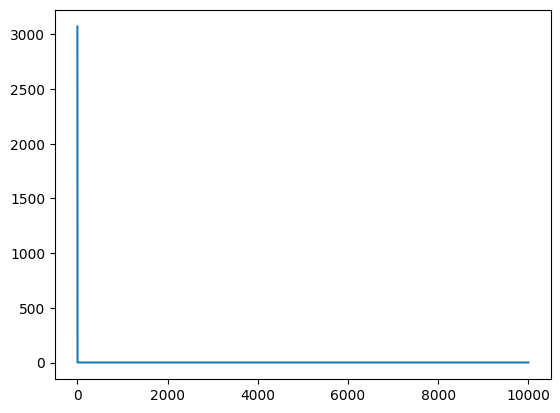

In [357]:
#Exemplo:
ans3 = AdaOja_Coord_real(X, k, eta=10*1e-1, b0=1e-5, random=False)
 
error_AdaOja_Coord_real = ans3[0]

plt.plot(error_AdaOja_Coord_real)
plt.show()

# Exercício 9: 

Implemente num mesmo gráfico os erros $\Vert W_k\Vert_F^2$ de cada método em CIFAR-10 em função no número de iterações.

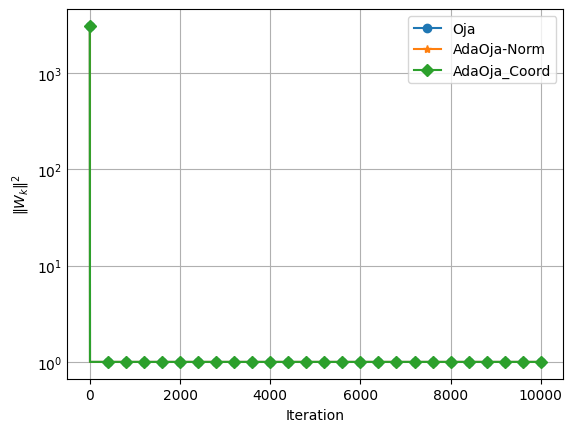

In [358]:
#Escreva código aqui
# Plotando as linhas
plt.plot(ans1[0], label = "Oja", marker = "o", markevery = 400)
plt.plot(ans2[0], label = "AdaOja-Norm", marker = "*", markevery = 400)
plt.plot(ans3[0], label = "AdaOja_Coord", marker = "D", markevery = 400)
# Ajustando os eixos
plt.xlabel("Iteration")
plt.yscale("log")
plt.ylabel(r"$\|W_k\|^2$")
plt.tick_params(axis = "y", which = "both", length = 0)
# Ativando a legenda e o grid
plt.legend()
plt.grid(True)